Author: Germano Gabbianelli

License: GNU GPL v3

## Import the required dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

## Configure the Random number Generators

We set an initial seed to ensure reproducibility

In [2]:
RANDOM_SEED = 666

We use a seed sequence to initialize all the possible random number generators.

In [3]:
seed_seq = np.random.SeedSequence(RANDOM_SEED)

MAP_SEED, ENV_SEED, ALG_SEED = seed_seq.spawn(3)

Unfortunately, for some reason, gym checks that the seeds are `int`s,
so we need this small trick

In [4]:
MAP_SEED = int(MAP_SEED.generate_state(1)[0])
ENV_SEED = int(ENV_SEED.generate_state(1)[0])

## Configure the FrozenLake Environment

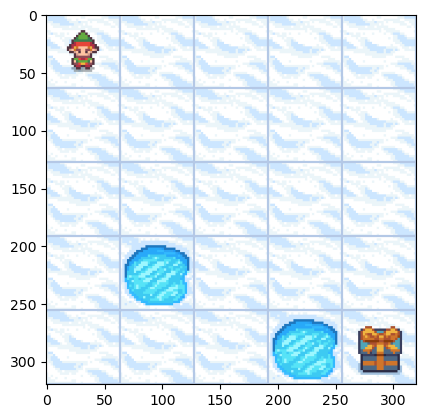

In [5]:
M = MAP_SIZE = 5
FROZEN_PROBABILITY=0.9

map = generate_random_map(
    size=MAP_SIZE,
    p=FROZEN_PROBABILITY,
    seed=ENV_SEED,
)
#print(map)

_map = [
    "FFFFF",
    "FHFFF",
    "FHFHF",
    "FHHHF",
    "FFSHG"
]

env = gym.make(
    "FrozenLake-v1",
    is_slippery=False,
    render_mode="rgb_array",
    desc=map,
)


env.reset(seed=ENV_SEED) # set the random seed

env_image = env.render()
plt.imshow(env_image)

## Define an Interface for our Algorithms

In [6]:
import abc

class Algorithm(abc.ABC):

    def __init__(self, env, df=0.95, seed=None):
        self.env = env
        self.df = df
        
        # useful as a shortcut
        self.S = env.observation_space.n
        self.A = env.action_space.n

        # initialize the random number generator
        self.rng = np.random.default_rng(seed)


    def step(self, t):
        raise NotImplementedError

    @abc.abstractproperty
    def policy(self):
        raise NotImplementedError

We also define some utility functions/classes (hidden by default)

In [7]:
## Utility functions/classes

def plot_policy(policy):

    U = (policy[:, 2] - policy[:, 0]).reshape(M, M)
    V = (policy[:, 3] - policy[:, 1]).reshape(M, M)

    x = np.arange(M) + 0.5
    X, Y = np.meshgrid(x, x[::-1])

    #U = np.ones(25).reshape(5,5)
    #V = U

    fig, ax = plt.subplots()


    ax.imshow(env_image, extent=[0, M, 0, M])

    ax.quiver(X, Y, U,V, angles='xy', scale_units='xy', scale=2)
    ax.set(xlim=[0,M], ylim=[0,M], aspect="equal")

    plt.show()

    
def compute_P(env):
    S = env.observation_space.n
    A = env.action_space.n

    P = P = np.zeros((S, A, S))

    for (state, state_data) in env.P.items():
        for (action, next_data) in state_data.items():
            for (prob, next_state, reward, terminated) in next_data:
                P[state, action, next_state] = prob

    return P


def compute_R(env):
    S = env.observation_space.n
    A = env.action_space.n

    R = np.zeros((S, A, S))

    for (state, state_data) in env.P.items():
        for (action, next_data) in state_data.items():
            for (prob, next_state, reward, terminated) in next_data:
                R[state, action, next_state] = reward

    return R


class InvalidatePolicy:
    def __set_name__(self, owner, name):
        self.name = name

    def __set__(self, instance, value):
        instance.__dict__[self.name] = value
        instance.__dict__.pop("policy", None)

## Linear Programming Formulation Recap

The Reinforcement Learning Problem can be formulated with the following two linear programs:

$\newcommand{\One}[1]{1\!\!1\{#1\}}$
$$
    \begin{aligned}[c]
        & \max_{\mu\succeq 0}\; \langle \mu, r \rangle \\
        & \textrm{subject to}\ E^\intercal \mu =(1-\gamma)\nu_0 + \gamma P^\intercal \mu \\
    \end{aligned}\quad\;\;
    \begin{aligned}[c]
    &\min_{v}\; (1-\gamma) \langle \nu_0, v\rangle \\
    &\textrm{subject to}\ Ev \geq r+\gamma Pv,
    \end{aligned}
$$

From which we can derive the Lagrangian

$$
\begin{aligned}
\mathcal{L}(v, \mu) &= (1-\gamma)\langle\nu_0, v\rangle + \langle\mu, r+\gamma Pv - Ev\rangle \\
 &= \langle\mu, r \rangle + \langle v, (1-\gamma)\nu_0 + \gamma P^\intercal \mu - E^\intercal \mu \rangle .
\end{aligned}
$$

We then use the gradients of the Lagrangian as losses for two alternativing mirror descent / ascent instances

$$
\begin{aligned}
\nabla_\mu \mathcal{L}(v, \mu) &= r+\gamma Pv - Ev\\
\nabla_v \mathcal{L}(v, \mu) &= (1-\gamma)\nu_0 + \gamma P^\intercal \mu - E^\intercal \mu
\end{aligned}
$$

<!--
Now consider the random variable $W=(X_0, X, A, R, X')$, where $X_0\sim \nu_0$,
$(X,A)\sim\mu$, $R=r(X,A)$, and $X'\sim p(\cdot\mid X,A)$. Then, we can define
the unbiased estimators

*   $\hat{\nu}_0(x) = \One{X^0=x}$,
*   $\hat{r}(x,a)= \One{X=x, A=a}R$
*   $\hat{p}(x'\mid x,a)=\One{X'=x'\mid X=x, A=a}$ -->

## A base class for our Tabular algorithms

In [8]:
from functools import cached_property


class TabularBase(Algorithm):

    # Makes sure the policy is deleted every time mu_sum is assigned
    mu_sum = InvalidatePolicy()

    def __init__(self, env, **kwds):
        lr_v = lr_mu = kwds.pop("lr", 0.01)
        self.lr_v = kwds.pop("lr_v", lr_v)
        self.lr_mu = kwds.pop("lr_mu", lr_mu)
        
        super().__init__(env, **kwds)

        # initialize variables
        self.v = np.zeros(self.S)
        self.mu = np.ones((self.S, self.A)) / (self.S * self.A)
        self.mu_sum = self.mu


    # @cached_property computes the attribute on first access and then caches it
    @cached_property
    def P(self):
        return compute_P(self.env)

    @cached_property
    def r(self):
        R = compute_R(self.env)
        return (self.P * R).sum(2)

    @property
    def nu0(self):
        return self.env.initial_state_distrib

    @cached_property
    def policy(self):
        return self.mu_sum / self.mu_sum.sum(1).reshape(-1, 1)


We define a small utility class to log the value of the policies produced by our
algorithm during training (hidden by default):

In [9]:
class LoggingMixin:
    "Utility class which evaluates the current policy at each step\
     and saves the values in `_rewards`."
    
    def __init__(self, env, *args, log_every=10, **kwds):
        super().__init__(env, *args, **kwds)

        self._log_every = log_every
        self._I = np.eye(self.S)
        self._rewards = []

    def evaluate_policy(self, policy):
        P = (self.P * policy.reshape(self.S, self.A, 1)).sum(1)
        r = (self.r * policy).sum(1)

        v = np.linalg.inv(self._I - self.df * P) @ r
        return (1-self.df) * self.nu0 @ v

    def step(self, t):
        super().step(t)

        if t % self._log_every == 0:
            r = self.evaluate_policy(self.policy)
            self._rewards.append(r)

## Compute the exact solution with a solver

In [10]:
from scipy.optimize import linprog


class PrimalSolver(TabularBase):
    def __init__(self, *args, **kwds):
        super().__init__(*args, **kwds)
        
        E = np.zeros((self.S, self.A, self.S))
        ii = np.arange(self.S)
        
        E[ii, :, ii] = 1
        
        self.E = E
        
    
    def step(self, t=0):
        
        SA = self.S * self.A
        
        r = self.r.reshape(SA)
        P = self.P.reshape(SA, self.S)
        E = self.E.reshape(SA, self.S)
        
        self._primal = primal = linprog(
            c = -r,
            A_eq = E.T - self.df * P.T,
            b_eq = (1 - self.df ) * self.nu0,
            bounds = (0, None),
        )
        
        mu = primal.x.reshape(self.S, self.A)
        nu = mu.sum(1)
        
        # We set the policy to be uniform for states
        # not visited by the deterministic optimal policy
        # produced by the solver
        mu[nu == 0] = 1 / self.A
        
        self.mu = self.mu_sum = mu

In [11]:
agent = PrimalSolver(env)
agent.step()

In [12]:
print(agent._primal)

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -0.034916864804687524
              x: [ 0.000e+00  5.000e-02 ...  0.000e+00  0.000e+00]
            nit: 25
          lower:  residual: [ 0.000e+00  5.000e-02 ...  0.000e+00
                              0.000e+00]
                 marginals: [ 3.492e-02  0.000e+00 ...  0.000e+00
                              0.000e+00]
          upper:  residual: [       inf        inf ...        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          eqlin:  residual: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
                 marginals: [-6.983e-01 -7.351e-01 ... -0.000e+00
                             -0.000e+00]
        ineqlin:  residual: []
                 marginals: []
 mip_node_count: 0
 mip_dual_bound: 0.0
        

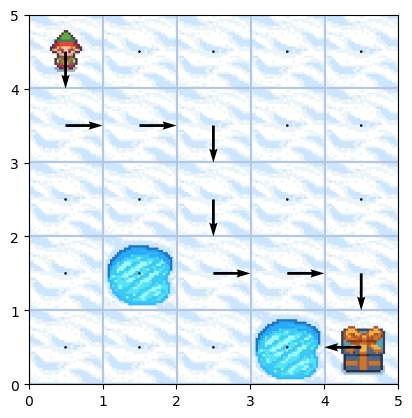

In [13]:
plot_policy(agent.policy)

### Let's do the same with the Dual

In [105]:
class DualSolver(TabularBase):
    
    def __init__(self, *args, **kwds):
        super().__init__(*args, **kwds)
        
        E = np.zeros((self.S, self.A, self.S))
        ii = np.arange(self.S)
        
        E[ii, :, ii] = 1
        
        self.E = E
    
    def step(self, t=0):
        
        SA = self.S * self.A
        r = self.r.reshape(SA)
        P = self.P.reshape(SA, self.S)
        E = self.E.reshape(SA, self.S)


        dual = linprog(
            c=(1 - self.df) * self.nu0,
            A_ub=self.df * P - E,
            b_ub=-r,
            bounds=(None, None),
        )
        print(dual)
        self._dual = dual       

        self.v = dual.x.reshape(self.S)
        self.q = (r + self.df * P @ self.v).reshape(self.S, self.A)
        
        
        #self.mu = self.mu_sum = mu
        
    @cached_property
    def policy(self):
        pi = np.zeros((self.S, self.A))
        ii = np.arange(self.S)
        
        pi[ii, self.q.argmax(1)] = 1
        return pi

In [107]:
agent = DualSolver(env)
agent.step()

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 0.03491686480468752
              x: [ 6.983e-01  7.351e-01 ... -0.000e+00 -0.000e+00]
            nit: 21
          lower:  residual: [       inf        inf ...        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          upper:  residual: [       inf        inf ...        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 3.492e-02 -0.000e+00 ... -0.000e+00
                             -0.000e+00]
                 marginals: [-0.000e+00 -0.000e+00 ... -0.000e+00
                             -0.000e+00]
 mip_node_count: 0
 mip_dual_bound: 0.0
        mi

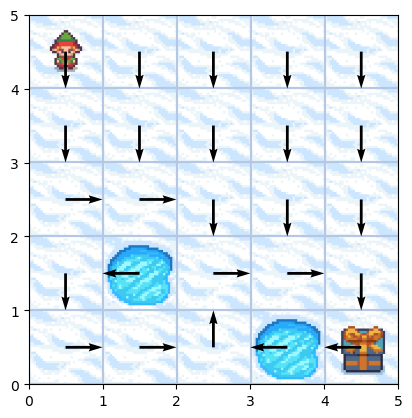

In [110]:
plot_policy(agent.policy)

## Our first algorithm: Distributional Primal Dual

In [15]:
class DistribPD(TabularBase):


    def grad_mu(self, v):
        return self.r + self.df * self.P @ v - v.reshape(-1, 1)

    def grad_v(self, mu):
        PT = self.P.reshape(self.S * self.A, self.S).T
        return (1 - self.df) * self.nu0 + self.df * PT @ mu.reshape(-1) - mu.sum(1)

    def step_v(self):
        grad = self.grad_v(self.mu)

        v = self.v - self.lr_v * grad

        v_min = 0
        v_max = 1/(1-self.df)
        return np.clip(v, v_min, v_max)


    def step_mu(self):
        grad = self.grad_mu(self.v)

        p = self.mu * np.exp(self.lr_mu * grad)
        mu = p / p.sum()
        return mu

    def step(self, t):
        v = agent.step_v()
        mu = agent.step_mu()

        self.v = v
        self.mu = mu
        self.mu_sum += mu

class LoggingDistribPD(LoggingMixin, DistribPD):
    pass


In [29]:
n = 20_000
lr = 1/np.sqrt(n)

agent = LoggingDistribPD(env, lr=lr)

In [30]:
for t in range(n):
    agent.step(t)

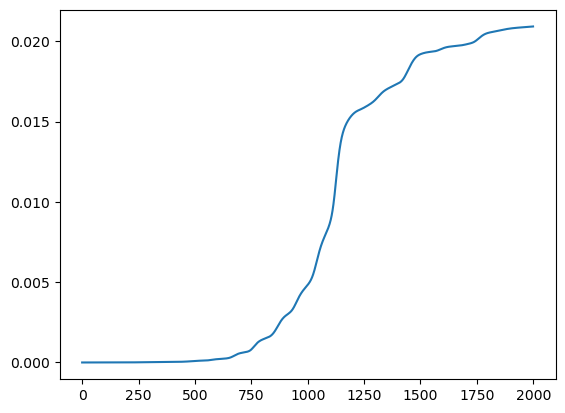

In [31]:
plt.plot(agent._rewards)

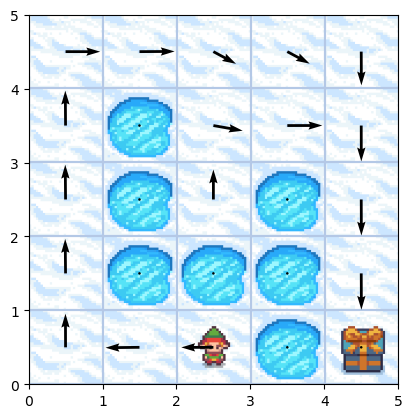

In [32]:
plot_policy(agent.policy)

## Second Algorithm: Tabular Primal Dual with Generative Model

If $X$ and $A$ are sampled from the uniform distribution over the state-action space. Then,

$$
\newcommand{\S}{\mathcal{S}}
\newcommand{\A}{\mathcal{A}}
\nabla_\mu \mathcal{L}(v, \mu) = |\S||\A|\cdot \mathbb{E}[ r(X,A) + \gamma v(X') - v(X) ]
$$

If $X$ and $A$ are sampled according to $\mu$. Then,

$$
\nabla_v \mathcal{L}(v, \mu)_x = \mathbb{E}[ \One{X^0 = x} + \gamma \One{X' = x} - \One{X = x} ]
$$

In [33]:
SampleDT = [(x, int) for x in ["s0", "s", "a", "r", "next_s"]]


def collect_sample(env, s, a):
    s0 = env.s
    
    env.unwrapped.s = s # the hours I spent before I realized I had to put `unwrapped` here. You have no idea.
    next_s, r, *_ = env.step(a)
    
    return np.rec.array((s0, s, a, r, next_s), dtype=SampleDT)


class GenerativePD(DistribPD):


    def sample_action(self, state):
        p = self.mu[state]
        return self.rng.choice(self.A, p = p / p.sum())

    def sample_state(self):
        return self.rng.choice(self.S, p = self.mu.sum(1))


    def grad_mu(self, v):
        w = self.sample

        grad = np.zeros((self.S, self.A))
        grad[w.s, w.a] = (w.r + self.df * v[w.next_s] - v[w.s]) * self.S * self.A #/ self.mu[w.s, w.a] #
        return grad

    def grad_v(self, mu):
        w = self.sample

        grad = np.zeros(self.S)
        grad[w.s0] = (1 - self.df)
        grad[w.next_s] += self.df
        grad[w.s] -= 1
        #grad -= mu.sum(1)
        #grad[w.next_s] += self.df * mu[w.s, w.a] - mu[w.next_s].sum()
        return grad


    def step(self, t):  
        # update for mu
        s = self.rng.choice(self.S)
        a = self.rng.choice(self.A) 
        self.sample = collect_sample(self.env, s, a)
        
        mu = self.step_mu()
        
        # reset the env to get a fresh sample from the initial distrib
        self.env.reset()
        
        # update for v
        s = self.sample_state()
        a = self.sample_action(s)
        self.sample = collect_sample(self.env, s, a)

        v = self.step_v()

        
        # set the variables
        self.v = v
        self.mu = mu
        self.mu_sum += mu


class LoggingGenerativePD(LoggingMixin, GenerativePD):
    pass

In [37]:
n = 500_000 # 40_000
lr = 0.0031

agent = LoggingGenerativePD(
    env,
    lr_v = lr,
    lr_mu = lr / 3,
    log_every = 1000,
    seed = ALG_SEED
)

In [38]:
for t in range(1, n):
    #agent.lr = 1/np.sqrt(t)
    agent.step(t)

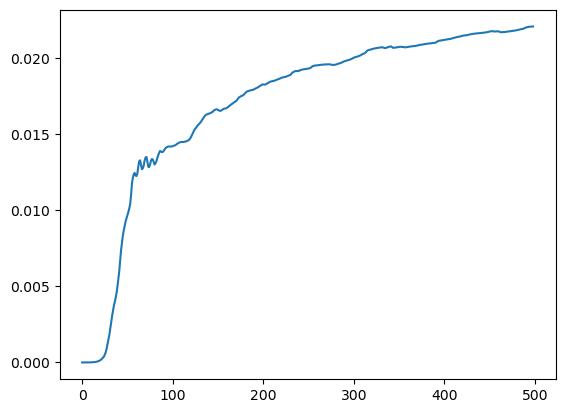

In [39]:
plt.plot(agent._rewards)

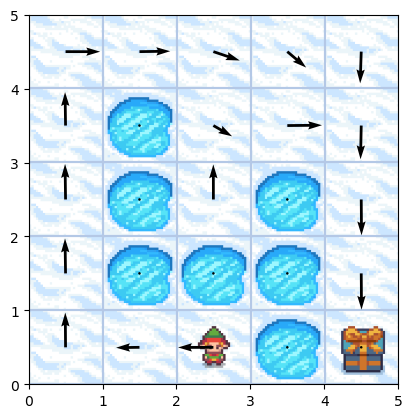

In [40]:
plot_policy(agent.policy)